# `photoeccentric` eccentricity fit

In this tutorial, I will use a Kepler light curve to demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os
import scipy
import corner


import photoeccentric as ph

%load_ext autoreload
%autoreload 2

# pandas display option
pd.set_option('display.float_format', lambda x: '%.5f' % x)
matplotlib.rcParams.update({'font.size': 22})

muirhead_comb = pd.read_csv('../datafiles/muirhead_comb.csv')
muirheadKOIs = pd.read_csv('../datafiles/MuirheadKOIs.csv')
lcpath = '../datafiles/sample_lcs'

plt.rcParams['figure.figsize'] = [20, 10]

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I'm going to pick a planet to test how well `photoeccentric` works. Here, I'm picking KOI 818.01.

In [19]:
nkoi = 818.01

### I define the mass and radius to create our stellar density prior.

In [20]:
mass = 0.56454
radius = 0.55833
rho_star = ph.density(mass, radius)
rho_star_err = 1

I'll define a KeplerStar object with `ph.KeplerStar(skoi)`, where `skoi` is the integer KOI identifier (818 for KOI 818.01).

In [21]:
SKOI = int(np.floor(float(nkoi)))

star = ph.KeplerStar(SKOI)

Now, I can define a KOI object with `ph.KOI(nkoi, SKOI, isodf)` where `nkoi` is the KOI planet identifier (818.01 in this case), `SKOI` is the integer KOI identifier as above, and `isodf` is a `pandas` dataframe constaining the consistent MESA stellar isochrones, which we created above.

The `koi` object will have all the same attributes as the `KeplerStar` object -- defining a `KeplerStar` object is not explicitly necessary.

In [22]:
koi = ph.KOI(nkoi, SKOI)

koi.mstar = mass
koi.rstar = radius
koi.rho_star = rho_star
koi.rho_star_err = rho_star_err

I'm pulling the planet parameters of Kepler-691 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, radius ratio, inclination, and more parameters for this planet.

I can use `koi.get_KIC` to get the Kepler Input Catalog number for the KOI.

And I can use the `koi.download_planet_params()` function to download planet properties from the Exoplanet Archive. The properties will become attributes of the `koi` object.

In [23]:
params = koi.download_planet_params()

print('KIC: ', koi.KIC)
print('Kepler Name: ', koi.kepname)
print('Period (days): ', koi.period)
print('Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)
print('b: ', koi.b)

KIC:  4913852.0
Kepler Name:  ['Kepler-691 b']
Period (days):  8.11437482
Rp/Rs:  0.037204
a/Rs:  23.58
b:  0.573


I can also view all the planet parameters available in the Exoplanet Archive as a `pandas` DataFrame:

In [24]:
params

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,4913852,K00818.01,Kepler-691 b,288.81201,0.00000,19h15m14.88s,40.03340,0.00000,+40d02m00.2s,17.47400,...,0,0,10.55000,2.46000,-2.31000,3.76716,2.38541,-3.13735,LS+MCMC,1.00000


In [25]:
koi.calc_a(koi.mstar, koi.rstar)

print('Stellar mass (Msun): ', koi.mstar, 'Stellar radius (Rsun): ', koi.rstar)
print('Period (Days): ', koi.period, 'Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)

# This isn't the true inclination of KOI 818.01, but for this example, we'll create an edge-on transit.
koi.i = 90.
print('i (deg): ', koi.i)

Stellar mass (Msun):  0.56454 Stellar radius (Rsun):  0.55833
Period (Days):  8.11437482 Rp/Rs:  0.037204
a/Rs:  25.131726892963254
i (deg):  90.0


Define a KeplerStar object, and use  ph.get_stellar_params and the fit isochrones to get the stellar parameters.

# Fitting the light curve

I'll define the working directory here. Our transit and eccentricity fits will be saved here.

In [26]:
# Define the working directory
direct = str(nkoi) + '/'

First, reading in the light curves that I have saved for this planet.

In [27]:
koi.download_lightcurves()

COMPLETE:  mastDownload.tar.gz


The `get_stitched_lcs` function stitches light curves for this star together, preserving the time stamps.

In [29]:
koi.get_stitched_lcs()

### I'll sigma clip (by Kepler quarter) and delete the nans.

In [30]:
koi.sigma_clip_quarters()
koi.delete_nans()

The `get_midpoints` function calculates the transit midpoints for this planet from the period and transit epoch in the literature.

In [31]:
koi.get_midpoints()

Let's plot the light curve for this object:

Text(0.5, 1.0, 'KOI 818 Kepler Light Curve')

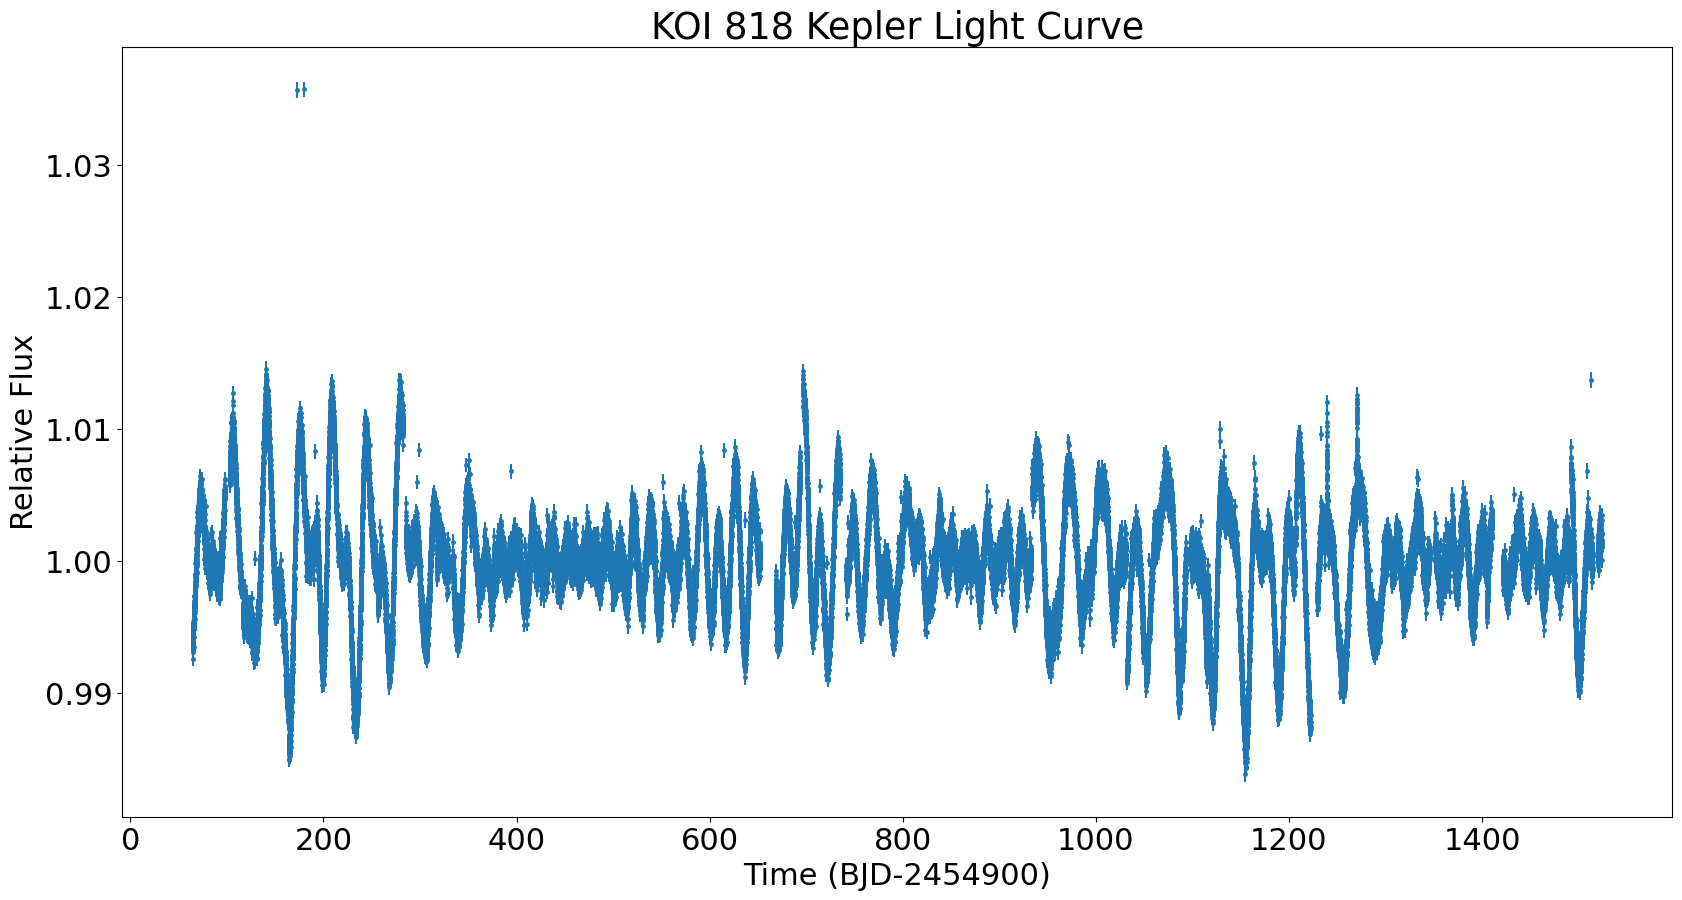

In [32]:
plt.errorbar(koi.time, koi.flux, yerr=koi.flux_err, fmt='.')
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Relative Flux')
plt.title('KOI 818 Kepler Light Curve')

##### Removing Out of Transit Data

The `remove_oot_data` function removes the out-of-transit segments of the light curve. Then, it fits a line to the light curve immediately before and after the transit, and subtracts the linear fit to the entire in-transit segment.

First, we must define `lc_nbuffer` and `lc_nlinfit`. 

`lc_nbuffer` is the number of points we would like to preserve before and after transit midpoint. Here, I want to preserve around 3.5 hours of time and flux data before and after the transit midpoint. I set `lc_nbuffer` to 7, so I save 7 Kepler flux points (sampled every 30 minutes = 3.5 hours) before and after the transit midpoint

`lc_linfit` is the number of points we would like to use in the linear fit. Here, I set `lc_linfit` to 6. The transit duration is about 1.5 hours long, so it spans around 3 Kepler time stamps (sampled every 30 minutes = 1.5 hours). The `remove_oot_data` function will take the 6 outermost light curve points from each end of the segment cut out using `lc_nbuffer`, which is 15 points long. It will fit a line to the outermost 12 points, then subtract that linear fit from the entire transit segemnt.

In [33]:
lc_nbuffer = 14
lc_nlinfit = 10

#koi.remove_oot_data(lc_nbuffer, nlinfit=lc_nlinfit, cubicfit=False, include_nans=False, delete_nan_transits=True, nan_limit=5)
koi.remove_oot_data(lc_nbuffer, nlinfit=lc_nlinfit, cubicfit=True, include_nans=False, delete_nan_transits=True, nan_limit=5)

100%|██████████| 180/180 [00:00<00:00, 1507.82it/s]


Let's plot the light curve with only in-transit points:

(0.995, 1.005)

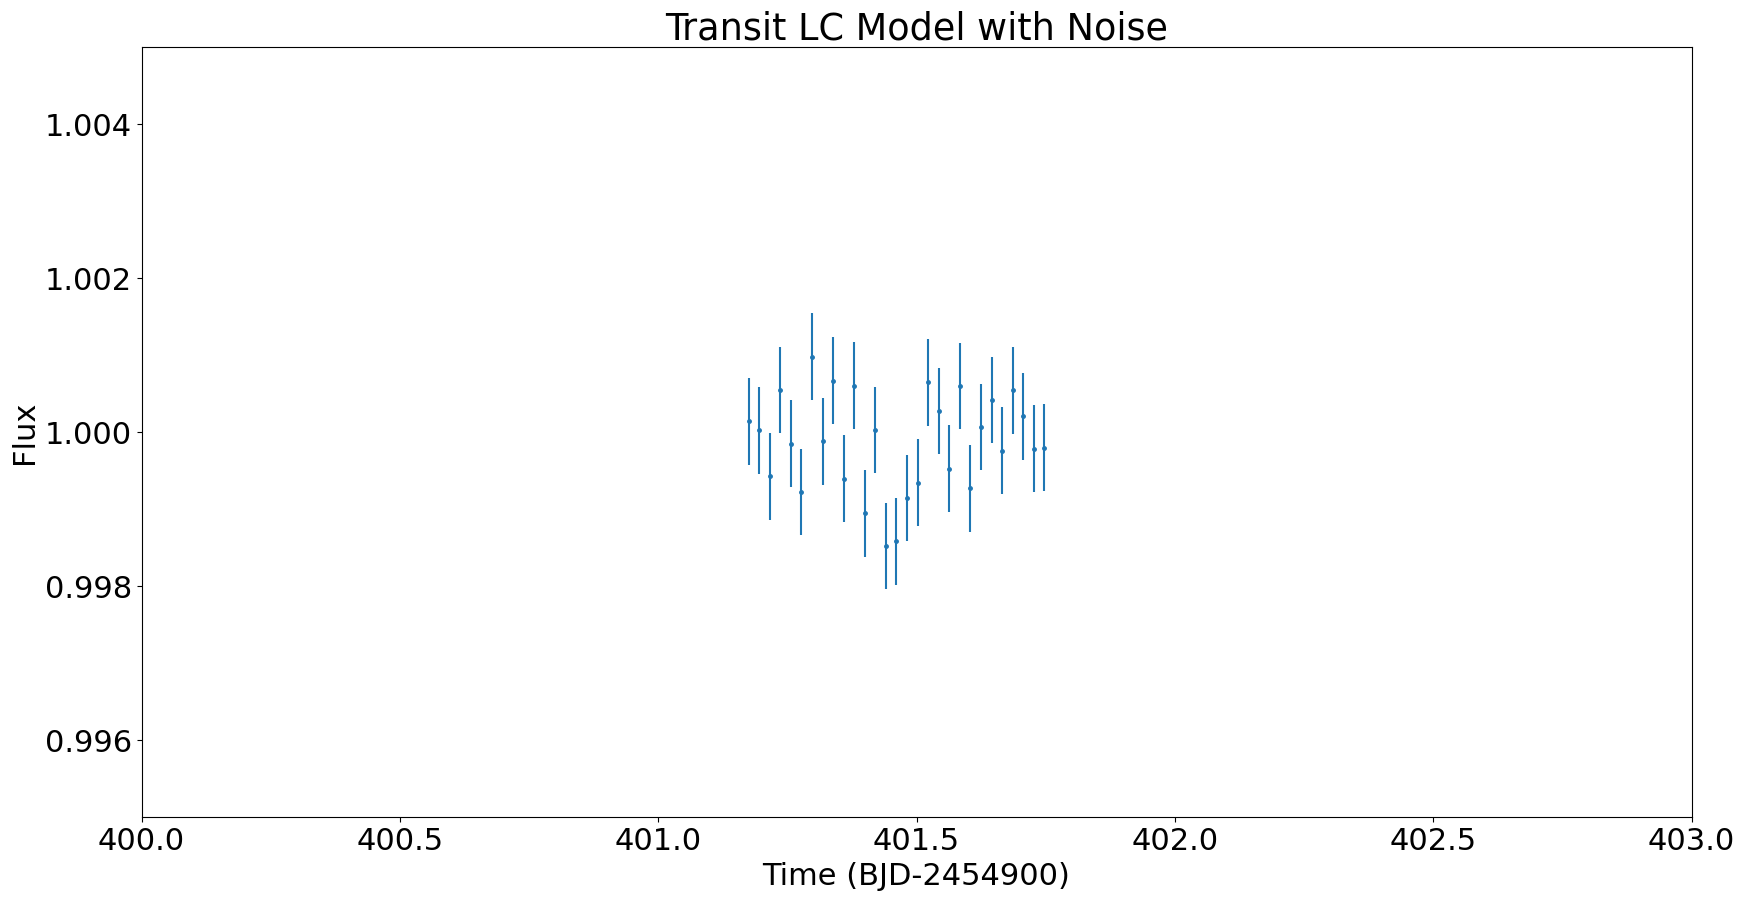

In [34]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='.')
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

plt.xlim(400,403.0)
plt.ylim(0.995, 1.005)

In [35]:
nsupersample=29
exptimesupersample=0.0201389

In [36]:
trace = koi.do_tfit_exoplanet(oversample=nsupersample, exptime=exptimesupersample, tune=1000, draw=2000)

Sequential sampling (2 chains in 1 job)
NUTS: [ecs, ror, rho_star, q2, q1, b, t0, period]


In [ ]:
import arviz as az

az.summary(trace)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

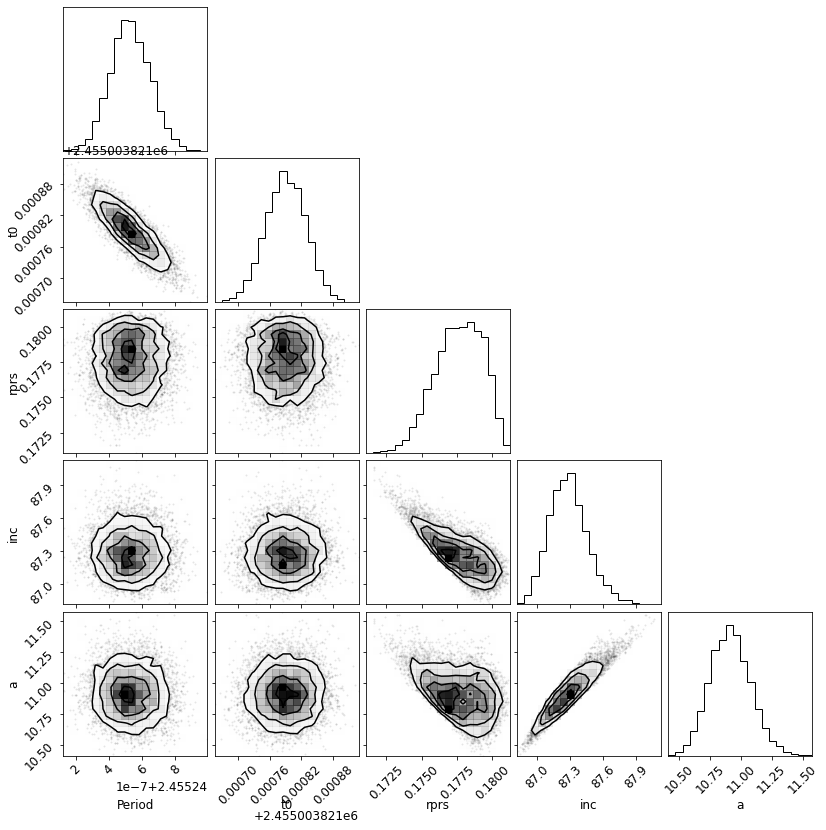

In [ ]:
_ = corner.corner(trace, var_names=['period', 't0', 'ror', 'b', 'ecc', 'omega', 'rho_star'])

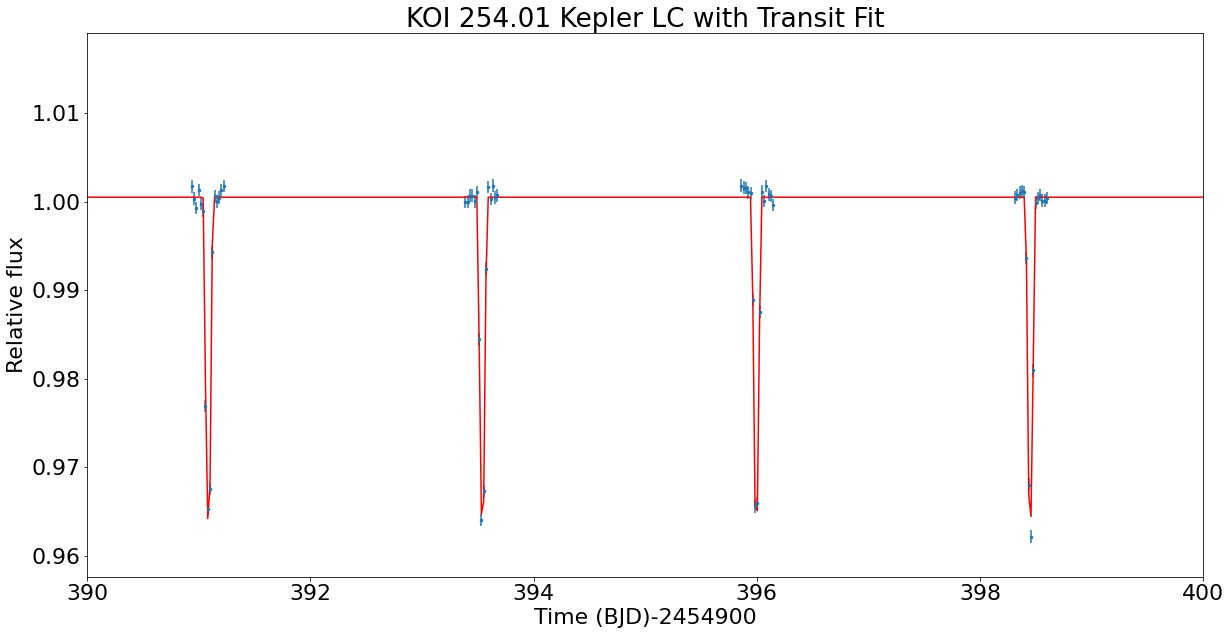

In [ ]:
samples = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p = np.median(samples["period"])
t0 = np.median(samples["t0"])
rprs = np.median(samples["ror"])
b = np.median(np.abs(samples["b"]))
ecc = np.median(samples["ecc"])
omega = np.median(samples["omega"])


# Plot the folded model
pred = np.percentile(samples["light_curves"], [16, 50, 84], axis=-1)
plt.plot(koi.time, pred[1], color="C1", label="model")